# Housing in Eau Claire, Wisconsin, USA.
We direct you to the report we made to for a description of the business problem and an explanation of the steps and choices we take. This is the notebook we'll use to actually perform the scraping and neighborhood analysis of homes in Eau Claire for our clients. 

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
from sklearn.preprocessing import StandardScaler

# Web stuff
from bs4 import BeautifulSoup
import requests
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options

# Map stuff
from geopy.geocoders import Nominatim as Nom
import folium

## 1. Definition of some helper functions, and of Listing and Venue classes
In this section, we will define a function, <code>listing_parser</code> used to parse/scrape the HTML of the house listings from Trulia.com. We also define our classes, <code>Listing</code> and <code>Venue</code>, which we will use to store the scraped data and also the fetched Foursquare API data. 

In [2]:
# Define our Listing and Venue classes, where we will store the data we get from Foursquare and Trulia. 
class Listing:
    def __init__(self, addr : str, web : str, ll : tuple, parsed_link_text : tuple):
        self.addr = addr
        self.price, self.beds, self.bath, self.sqft = parsed_link_text
        self.web = web
        self.ll = ll
        self.venues = []
        
class Venue:
    def __init__(self, name, cat = None, ll = None, web = None):
        self.name = name
        self.cat = cat
        self.ll = ll
        self.web = web
    
    def get_link(self):
        return "https://foursquare.com/v/" + self.web

In [3]:
# This function parses the link text style of Trulia. 
# Examples:
#    $174,9003bd1ba1,392 sqft1708 Rist AveEau Claire, WI
#    NEW$125,9004bd2ba1,912 sqft1904 3rd St #1-2West Riverside, Eau Claire, WI
#    FOR SALE BY OWNER$110,0001bd1ba560 sqft2710 Starr AveAirport, Eau Claire, WI
def listing_parser(a: str):
    # Start the address string at "$"
    a = a[a.find("$"):]
    
    # Find marker substrings
    bd_loc = a.find("bd")
    ba_loc = a.find("ba")
    sqft_loc = a.find("sqft")
    
    # Find the list price, beds, baths, square feet
    #   The addresses are also here, but more difficult to parse.
    #   It's much easier to just get div tags with
    #    {"data-testid" : "property-street"} and {"data-testid" : "property-region"}
    #   from BeautifulSoup for the address.
    price = a[:bd_loc-1]
    bd = a[bd_loc - 1]
    ba = a[ba_loc - 1]
    sqft = a[ba_loc+2 : sqft_loc-1]
    
    return (price, bd, ba, sqft)

In [4]:
# Functions to automate the task of GETting results from the Foursquare API. 

# This enacts a "search" call to Foursquare, with query='cat' and radius ~ 1.5 miles (2414 meters).
def ven_type_get(L : Listing, cat: str):
    with open("idsec", "r") as info:
        ID, SECRET = info.readlines()
    URL = "https://api.foursquare.com/v2/venues/search?"
    PAR = {
        "client_id" : ID, 
        "client_secret" : SECRET, 
        "v" : "20170729",
        "ll" : "{},{}".format(L.ll[0], L.ll[1]),
        "query" : cat,
        "radius" : "2414", # 1.5 mile = 2414 meters
        "limit" : "50"
    }
    
    r = requests.get(url=URL, params=PAR).json()
    try:
        return r['response']['venues']
    except:
        print("Error when looking for {} places around {}".format(cat, L.addr))
        return None
    
# Enacts an "explore" call to Foursquare, with radius ~ 1.5 miles (2414 meters). 
# Optional parameter offset gives a starting point for the rankings to return;
#    e.g. offset="10" would return venues ranked 10 through 59.
def ven_explore(L : Listing, offset="0"):
    with open("idsec", "r") as info:
        ID, SECRET = info.readlines()
    URL = "https://api.foursquare.com/v2/venues/explore?"
    PAR = {
        "client_id" : ID, 
        "client_secret" : SECRET, 
        "v" : "20170729",
        "ll" : "{},{}".format(L.ll[0], L.ll[1]),
        "radius" : "750", 
        "offset" : offset,
        "limit" : "50"
    }
    
    # Get top 100 results. Foursquare limits to 50 venues per call, but allows for an "offest" parameter that also goes up to 50.
    PAR['offset'] = "0"
    r = requests.get(url=URL, params=PAR).json()

    venues = [v['venue'] for v in r['response']['groups'][0]['items']]
    
    return venues

In [5]:
# This function is used to filter places that are actually parks from "Park View Fitness", for example. 
# See the Find and Filter Nearby Venues section below.
def ven_check(venue):
    is_park = "4bf58dd8d48988d163941735"
    is_playground = "4bf58dd8d48988d1e7941735"
    is_bookstore = "4bf58dd8d48988d114951735"
    is_usedbookstore = "52f2ab2ebcbc57f1066b8b30"
    is_elemschool = "4f4533804b9074f6e4fb0105"
    is_midschool = "4f4533814b9074f6e4fb0106"
    is_highschool = "4bf58dd8d48988d13d941735"
    is_preschool = "52e81612bcbc57f1066b7a45"
    is_library = "4bf58dd8d48988d12f941735"
    is_coffeeshop = "4bf58dd8d48988d1e0931735"
    
    ok_venues = [is_park, is_playground, is_bookstore, is_usedbookstore, is_elemschool, is_midschool, is_highschool, is_preschool, is_library, is_coffeeshop]
    
    if venue['categories'][0]['id'] in ok_venues:
        return True
    else:
        return False

## 2. Start scraping
Now we do our scraping of the Trulia home listings. Our first tool is a headless Firefox browser, running in private mode. This gets us the HTML we want, which we parse using BeautifulSoup. Finally, we load the data into a list of Listing objects. 

Some more information on the steps:
1. We use the <code>selenium</code> webdriver for Firefox to get the HTML for the first and second pages of home listings on Trulia.com's Eau Claire page. Each time we call this Firefox object, it populates a <code>page_source</code> parameter with the code one would find by right clicking and using "View source" during normal browsing.
2. We send the source into <code>BeautifulSoup</code>'s HTML parser, which lets us search for blocks on the page by tags (e.g. <code>&lt;a href...&gt;</code> or <code>&lt;div...&gt;</code>). 

In [6]:
# Get our headless Firefox browser running. We'll use this to interact with Trulia. 
opts = Options()
opts.add_argument("-headless") 
opts.add_argument("-private") # Don't store cookies etc.
ffx = Firefox(executable_path="geckodriver", options=opts)

In [7]:
ffx.get("https://www.trulia.com/WI/Eau_Claire/")
soup_p1 = BeautifulSoup(ffx.page_source, "html.parser")

ffx.get("https://www.trulia.com/WI/Eau_Claire/2_p/")
soup_p2 = BeautifulSoup(ffx.page_source, "html.parser")

In [8]:
# We are done with the browser, so we can kill this instance.
ffx.close()

### 2.1. Parse HTML to get listings
The next block is where we find the listings on the websites. While we've already downloaded the HTML files from Trulia, and stored them in <code>soup_p1</code> and <code>soup_p2</code>, we still need to look into those files and extract/scrape the listings. 

Our scraping is done by searching for links in the page, i.e. <code>&lt;a href...&gt;</code> tags, and then checking the link text to see if the text ends with "WI". This gives us just the links to houses, not the many other links on these websites. 

When we find a housing link, we take the following steps:
1. Get the address by looking for certain <code>&lt;div...&gt;</code> tags within the block of the link. 
2. Call Nominatim to get the GPS coordinates based on that address. If Nominatim returns nothing (not every address is found) we just discard the listing and move on to the next one.
3. Parse the link text to extract the price, square footage, and bedroom and bathroom counts using the helper function from above. 
4. Create a Listing object, inputting the address, web address (Trulia listing), GPS, price, sqft, beds, and baths. Add this Listing to the Ls array, which we will iterate over in the next step to find venues on Foursquare.

In [9]:
Ls = [] # We're going to store the listings we find in here as Listing objects.

ll_getter = Nom(user_agent="firefox")

# Loop over all the links we find in the HTML, which are specified by <a href="...">
# -- find_all("a") searches the HTML and finds all the "a" tags.
for a in soup_p1.find_all("a"):
    t = a.text # this is TEXT in <a href="www.website.com">TEXT</a>
    
    # For addresses that correspond to a listing, t is going to be something like:
    #   t == '$889,9005bd5ba5,321 sqft28 Newton StThird Ward, Eau Claire, WI'
    # None of the other links on the page have endings of 'WI', so we check for this as a proxy for home listings.
    if t[-2:] == "WI": 
        # We found a listing address instead of some other link on the page!
        # Now, we will do some work to get the information necessary to feed into the Listing object constructor. 
        # For easy reference, the arguments are:
        #   (street address, web address, (price, beds, bath, square footage))
        
        # Get the street address
        street_addr = a.find("div", {"data-testid":"property-street"}).text
        street_addr += ", Eau Claire, WI"
        
        # Get/make the web address
        web_addr = 'https://www.trulia.com' + a.attrs['href']
        
        # Get the lat/lng coordinates of the listing
        ll = ll_getter.geocode(street_addr)
        
        # Some addresses can't be found on Nominatim. Just skip these.
        if ll == None:
            continue
        else:
            ll = ll[-1]
        
        # Run our listing_parser function on t to get the last parameter
        pbbs = listing_parser(t)
        
        Ls.append(Listing(street_addr, web_addr, ll, pbbs))
        
        # Nominatim has a policy of 1 request per second, as I learned by this loop not finishing.
        #   It will give slightly more, but be nice (24 returned befere denial, with 0.5 second wait). 
        time.sleep(1)
        
# Do this again for the second page from Trulia
for a in soup_p2.find_all("a"):
    t = a.text # this is TEXT in <a href="www.website.com">TEXT</a>
    
    # For addresses that correspond to a listing, t is going to be something like:
    #   t == '$889,9005bd5ba5,321 sqft28 Newton StThird Ward, Eau Claire, WI'
    # None of the other links on the page have endings of 'WI', so we check for this as a proxy for home listings.
    if t[-2:] == "WI": 
        # We found a listing address instead of some other link on the page!
        # Now, we will do some work to get the information necessary to feed into the Listing object constructor. 
        # For easy reference, the arguments are:
        #   (street address, web address, (price, beds, bath, square footage))
        
        # Get the street address
        street_addr = a.find("div", {"data-testid":"property-street"}).text
        street_addr += ", Eau Claire, WI"
        
        # Get the lat/lng coordinates of the listing
        ll = ll_getter.geocode(street_addr)
        
        # Some addresses can't be found on Nominatim. Just skip these.
        if ll == None:
            continue
        else:
            ll = ll[-1]
        
        # Get/make the web address
        web_addr = 'https://www.trulia.com' + a.attrs['href']
        
        # Run our listing_parser function on t to get the last parameter
        pbbs = listing_parser(t)
        
        Ls.append(Listing(street_addr, web_addr, ll, pbbs))
        
        # Nominatim has a policy of 1 request per second, as I learned by this loop not finishing.
        #   It will give slightly more, but be nice (24 returned befere denial, with 0.5 second wait). 
        time.sleep(1)

### 2.2. Find and filter nearby venues
Foursquare has a lot of venues, but we're just interested in a few types. 
* Coffee shops
* Libraries
* Bookstores (new or used)
* Parks and playgrounds
* Schools (pre-, elementary-, middle-, highschool)

Fortunately, Foursquare also has <a href="https://developer.foursquare.com/docs/resources/categories">unique strings identifying the type of a venue</a>. The function <code>ven_check</code>, defined with the other helper functions above, filters the venue lists we get, to ensure that the places we find by searching for "park" are actually parks and not a gym called something like "Park View Fitness".

In [10]:
key_venues = {}
for listing in Ls:
    key_venue_cats = [
        ven_type_get(listing, "coffee"),
        ven_type_get(listing, "library"),
        ven_type_get(listing, "school"),
        ven_type_get(listing, "bookstore"),
        ven_type_get(listing, "park")
    ]

    # We're now going to build our collection of venues. 
    # Before making a Venue object from our findings above, let's check they're actually
    # one of the venues of interest to our clients.
    for cat in key_venue_cats:
        for v in cat:
            # Get variables of interest out of the JSON. Each index lookup takes time in Python, so this could speed things up!
            
            # There are a few places that are 'uncategorized', like "School House" with Foursquare venue id 4dbb6cd4cda109aa6c820014...
            try:
                vcat = v['categories'][0]['name']
            except:
                # If that's the case, just skip it. We don't know enough about this venue...
                continue
                
            vid = v['id']
            vname = v['name']
            vll = (v['location']['lat'], v['location']['lng'])
            if ven_check(v):
                if (vid not in key_venues):
                    key_venues[vid] = Venue(vname, vcat, vll, vid)
                listing.venues.append(vid)

### 2.3. Estimate venue densities for each Listing
Now that we have our venues of interest processed, our last piece of data-fetching is to use some Foursquare <code>explore?</code> calls. The only thing we'll record here is the number of venues in a 750 meter radius around each listing; we use this to estimate the density of shopping and venues near Listings. Notice that we are confining our density search to a much smaller radius, because we are more interested in avoiding houses very close to shopping centers/downtown than what the specific venues are.

In [11]:
Ls_densities = []
for listing in Ls:
    # We record "density" as number of venues within 750 meters out of the 50 venues we asked for in ven_explore.
    Ls_densities.append(len(ven_explore(listing))/50)

In [13]:
# This dictionary is useful in several below steps, when linking venues to locations and categories.
cat_index_dict = {
    #'4bf58dd8d48988d1e0931735' : 0, # Coffee
    #'4bf58dd8d48988d12f941735' : 1, # Library
    #'4bf58dd8d48988d114951735' : 2, # Bookstore
    #'4bf58dd8d48988d1e7941735' : 3, # Playground
    #'4f4533804b9074f6e4fb0105' : 4, # Elem school
    #'4f4533814b9074f6e4fb0106' : 4, # Middle school
    #'4bf58dd8d48988d13d941735' : 4, # High school
    #'52e81612bcbc57f1066b7a45' : 4  # Preschool
    #'4bf58dd8d48988d163941735' : 3, # Park
    'Coffee Shop' : 0,  
    'Library' : 1,  
    'Bookstore' : 2,  
    'Park' : 3,  
    'Playground' : 3,
    'Elementary School' : 4,
    'Middle School' : 4,
    'High School' : 4,
    'Preschool' : 4             
}

In [14]:
ven_scores = np.zeros((len(Ls), 5))

In [15]:
for j in range(len(Ls)):
    for v in Ls[j].venues:
        # key_venues[v] is the actual Venue object, so get its cat(egory). Then get the index.
        category = cat_index_dict[key_venues[v].cat] 
        ven_scores[j, category] += 1

### 2.3. Encoding our findings in a DataFrame for modeling and clustering
Now that we have this information, we will encode the listings, venues of interest, and venues densities into a DataFrame which we use to build a model of the house listings for clustering.

In [16]:
listings_dict = {
    "Listing" : [l.addr for l in Ls], 
    "Density" : Ls_densities,
    "Coffee" : ven_scores[:,0],
    "Library" : ven_scores[:,1],
    "Bookstore" : ven_scores[:,2],
    "Park_Playground" : ven_scores[:,3],
    "School" : ven_scores[:,4]
}

In [17]:
listings_df = pd.DataFrame.from_dict(listings_dict)

In [18]:
listings_df.head()

,Listing,Density,Coffee,Library,Bookstore,Park_Playground,School
0,"6708 Timber Ln, Eau Claire, WI",0.06,0.0,0.0,0.0,2.0,0.0
1,"3105 State St, Eau Claire, WI",0.12,7.0,1.0,3.0,15.0,6.0
2,"425 Vine St, Eau Claire, WI",0.32,6.0,3.0,3.0,22.0,3.0
3,"4517 Wildwood Ct, Eau Claire, WI",0.24,7.0,0.0,1.0,5.0,2.0
4,"920 S Farwell St, Eau Claire, WI",0.46,7.0,2.0,3.0,21.0,6.0


In [19]:
# Get a feeling for the range and magnitude of these features
listings_df.describe()

,Density,Coffee,Library,Bookstore,Park_Playground,School
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,0.187407,4.277778,1.166667,1.296296,12.203704,3.722222
std,0.169274,2.777379,1.193536,1.409264,7.989095,2.013320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.080000,2.000000,0.000000,0.000000,5.000000,2.250000
50%,0.120000,5.000000,1.000000,1.000000,9.000000,3.000000
75%,0.255000,6.750000,2.000000,3.000000,21.000000,6.000000
max,0.720000,9.000000,3.000000,3.000000,22.000000,7.000000


## 3. OPTICS and K-means clustering

In [20]:
# We're going to scale the features related to specific venues.
# Since there are 3 to 7 times as many parks/playgrounds as other 
# features, the parks/playgrounds would dominate the categorizing otherwise.
sc = StandardScaler()

In [21]:
# Do the transformation on the listings, ignoring the "Address" column, column 0
listings_xfrm = sc.fit_transform(listings_df.iloc[:,1:])

In [22]:
# listings_xfrm is currently a numpy array. Change it into a DataFrame
listings_xfrm = pd.DataFrame(listings_xfrm)

In [25]:
# Use the same column headers as listings_df, instead of enumerated columns.
listings_xfrm.columns = listings_df.columns[1:]

In [290]:
# See what the transformed stats look like. The mean should be zero, 
# but in practice we expect a very, very small number instead of actual 0.
listings_xfrm.describe()

,Density,Coffee,Library,Bookstore,Park_Playground,School
count,5.400000e+01,5.400000e+01,5.400000e+01,5.400000e+01,5.400000e+01,5.400000e+01
mean,1.511137e-16,2.878356e-17,-5.139921e-17,-1.901771e-17,-2.878356e-17,-3.289550e-17
std,1.009390e+00,1.009390e+00,1.009390e+00,1.009390e+00,1.009390e+00,1.009390e+00
min,-1.117523e+00,-1.554683e+00,-9.866661e-01,-9.284767e-01,-1.541889e+00,-1.866158e+00
25%,-6.404779e-01,-8.278184e-01,-9.866661e-01,-9.284767e-01,-9.101588e-01,-7.381072e-01
50%,-4.019551e-01,2.624790e-01,-1.409523e-01,-2.122232e-01,-4.047750e-01,-3.620903e-01
75%,4.030593e-01,8.984858e-01,7.047615e-01,1.220284e+00,1.111376e+00,1.141977e+00
max,3.175887e+00,1.716209e+00,1.550475e+00,1.220284e+00,1.237722e+00,1.643333e+00


In [208]:
listings_xfrm.head()

,Density,Coffee,Library,Bookstore,Park_Playground,School
0,-0.759739,-1.554683,-0.986666,-0.928477,-1.289197,-1.866158
1,-0.401955,0.989344,-0.140952,1.220284,0.353301,1.141977
2,0.790659,0.625911,1.550475,1.220284,1.237722,-0.362090
3,0.313613,0.989344,-0.986666,-0.212223,-0.910159,-0.863446
4,1.625489,0.989344,0.704761,1.220284,1.111376,1.141977


In [209]:
# We want to cluster in two separate ways:
#  1. By density of venues within 750 meters of the listing
#  2. By number of our key venue categories within 1.5 miles of the listing
xfrm_density = listings_xfrm[['Density']]
xfrm_venues = listings_xfrm.iloc[:,1:]

In [85]:
## Clustering by density here. Using K-means because we know we want exactly 3 categories.
kmeans = KMeans(n_clusters=3)
kmeans.fit(xfrm_density)
kmeans_density = kmeans.labels_

In [254]:
# Set up the OPTICS algorithm. 
# -- min_samples=5 indicates we want no fewer than 5 Listings in a neighborhood around a point for that to be considered a core point
# -- cluster_method='xi' tells OPTICS to generate clusters based on the xi-steepness method; see Report.
# -- xi=0.05 indicates we want reachability distances to increase/decrease by 5% to be considered a cluster boundary.
optics = OPTICS(min_samples=5, cluster_method='xi', xi=0.05)

In [255]:
## Here we extract the results of OPTICS

# Fit OPTICS to the transformed venue counts
optics.fit(xfrm_venues)

# Extract the reachabilities *in the specific order OPTICS procesed them in*. 
venues_reachability = optics.reachability_[optics.ordering_]
# Extract the cluster labeling generated by the xi-steepness method. 
# -- A label of -1 indicates 'outlier/no cluster' (usually 'noise' but that doesn't really apply to house listings)
venues_labels = optics.labels_[optics.ordering_]

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [256]:
# Let's get the unique cluster labels
xi_labels = list(set(venues_labels))

In [257]:
# We see there are 5 natural clusters, plus the "outlier" cluster.
xi_labels

[0, 1, 2, 3, 4, -1]

In [279]:
# Set up the colors we will use in our reachability graph, and also on our Folium clustering map. Chosen to be visually distinctive.
ven_xi_colors = ['#ee00ff', '#08ff00', '#00fff6', '#0010ff', '#ff0000']

In [280]:
%matplotlib inline

Text(0.5, 1.0, 'OPTICS Reachability Plot for House Listings, by nearby venues of interest')

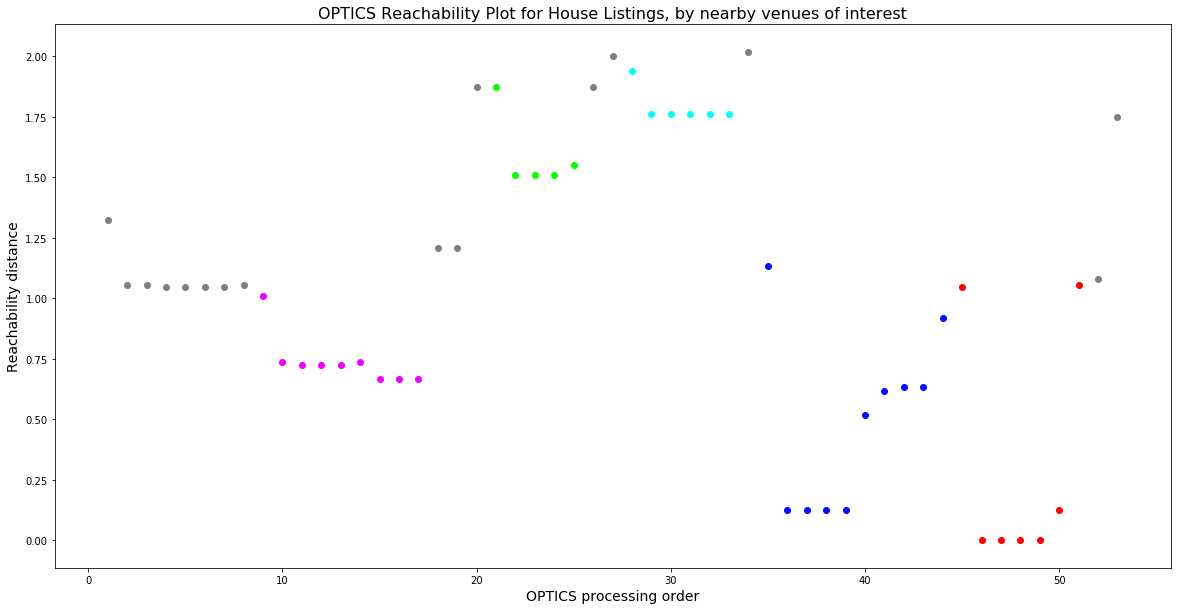

In [287]:
## Create the reachability graph

# Standard matplotlib figure setup
fig_reachability = plt.figure(figsize=(20,10))
ax_reach = fig_reachability.add_subplot(111)
domain = np.arange(len(venues_labels)) # Used for the x-values in our scatter plots

# This for loop will iterate over the xi_labels OPTICS found, scatterplotting the points according to their color
for j in xi_labels:
    # Make the outliers grey
    if j == -1:
        col = 'grey'
        #continue
    else:
        col = ven_xi_colors[j]
    
    # Get a True/False vector specifying which of the data points have the current label
    cluster = (venues_labels == j)
    ax_reach.scatter(domain[cluster], venues_reachability[cluster], c=col)
    
# Label our plot
ax_reach.set_xlabel("OPTICS processing order", fontsize=14)
ax_reach.set_ylabel("Reachability distance", fontsize=14)
ax_reach.set_title("OPTICS Reachability Plot for House Listings, by nearby venues of interest", fontsize=16)

# Output to an image file, for including in our report
plt.savefig("OPTICS_reachability_2.png")

## 4. The deliverables
We now have all the information we need to design our deliverables. The main component of our product will be two Folium maps of Eau Claire.
1. One map with the listings and venues plotted,. These are all going to be color-coded based on their DBSCAN cluster or venue category, respectively. The color coding for venue types is: 
    * Brown = Coffee shops
    * Teal = Libraries
    * Black = Bookstores (new or used)
    * Green = Parks and playgrounds
    * Pink = Schools (pre-, elementary-, middle-, highschool) 
    


2. One map with just the listings plotted, color-coded based on density. The color coding we are going to obtain by using a K-means clustering, with K=3 clusters. The coloring will be: green/yellow/red corresponding to low/medium/high density. 

In [33]:
ll_getter.geocode("Eau Claire, WI")

Location(Eau Claire, Eau Claire County, Wisconsin, United States of America, (44.811349, -91.4984941, 0.0))

In [291]:
venue_colors = ['#8f6200', '#00f2ff', '#000000', '#38d140', '#ff7de3'] # Brown, Teal, Black, Green, Pink

### 4.1. OPTICS xi clustering map

In [292]:
map_ec_1 = folium.Map(location=(44.811349, -91.4984941), zoom_start=13)


for k in key_venues.keys():
    v = key_venues[k]
    col = venue_colors[cat_index_dict[v.cat]]
    
    text = folium.Html(r'<a href="{}" target="_blank">{}</a><br>{}'.format(v.get_link(), v.name, v.cat), script=True)
    label = folium.Popup(text, parse_html=True)
    folium.CircleMarker( # Fixed pixel radius
        location = v.ll,
        popup = label,
        radius = 6,
        weight=1,
        fill = True,
        fill_color = col,
        fill_opacity = 0.8,
        parse_html = True
    ).add_to(map_ec_1)

for j in range(len(Ls)):
    
    # Get the house listing
    listing = Ls[j]
    
    # Here we need to match the clustering to the ordering of Ls. 
    # The thing to watch out for is that the classes found in venues_labels are 
    # indexed by optics.ordering_ instead of by the order of Ls.
    #==========================================================
    # Get the class that OPTICS placed this housing into
    L_class = optics.labels_[j]
    # Get the color corresponding to this class.
    if L_class == -1:
        col = 'grey' # outliers are grey
    else:
        col = ven_xi_colors[L_class] # same coloring as the reach. plot
    #==========================================================
    
    # Build the popup tag.
    #  - Have the address with a link to the Trulia listing.
    #  - Have beds, baths, price
    #  - Also give the DBSCAN class, to add to the clarity of the color scheme
    #  ~~~~> Sometimes the colors are similar, especially to color blind folks...
    #  ~~~~> We also are going to make a decision tree to give insight into the clusters, so this helps the client align the map colors with the tree.
    text = folium.Html(r'<a href="{}" target="_blank">{}</a><br>{} bed<br>{} bath<br>{}<br>Class: {}'.format(listing.web, listing.addr, listing.beds, listing.bath, listing.price, L_class), script=True)
    label = folium.Popup(text, parse_html=True)
    folium.CircleMarker( # Fixed radius in pixels
        location = listing.ll,
        popup = label,
        radius = 10,
        color='black',
        fill = True,
        fill_color = col,
        fill_opacity = 0.8,
        parse_html = False
    ).add_to(map_ec_1)
    

  
map_ec_1.save("Venues.html")
map_ec_1

## 4.2. K-means clustering of venue densities

In [110]:
map_ec = folium.Map(location=(44.811349, -91.4984941), zoom_start=13)

# Showing the client the density makes this map much more useful.
# Before, we calculated density as #(nearby top venues)/50. 
# We record max_dens to normalize densities to be out of 1, since nowhere had 50 top venues within 750 meters.
max_dens = listings_df['Density'].max()
colrs = ['#00ff00', '#cc2900', '#ffcc66', ] # ffcc66,yellow || cc2900,red || 00ff00,green
for j in range(len(kmeans_density)):
    
    # Get the house listing
    listing = Ls[j]
    # Rate its density
    density = listings_df.iloc[j]['Density']
    density = density/max_dens
    
    # Get the color for the house, based on 3-means clustering outcome
    col = colrs[kmeans_density[j]]
    
    # Build the popup tag to include a link to the Trulia listing, some details about the house, and the density.
    text = folium.Html(r'<a href="{}">{}</a><br>{} bed<br>{} bath<br>{}<br>Density: {:.2f}'.format(listing.web, listing.addr, listing.beds, listing.bath, listing.price, density), script=True)
    label = folium.Popup(text, parse_html=True)
    
    # Place a CircleMarker on the map
    folium.CircleMarker( # Fixed pixel radius
        location = listing.ll,
        popup = label,
        radius = 10,
        fill = True,
        fill_color = col,
        fill_opacity = 0.8,
        parse_html = True
    ).add_to(map_ec)

# Output the produced HTML map for easy sharing!
map_ec.save("Density.html")

# Display the map in our Notebook.
map_ec

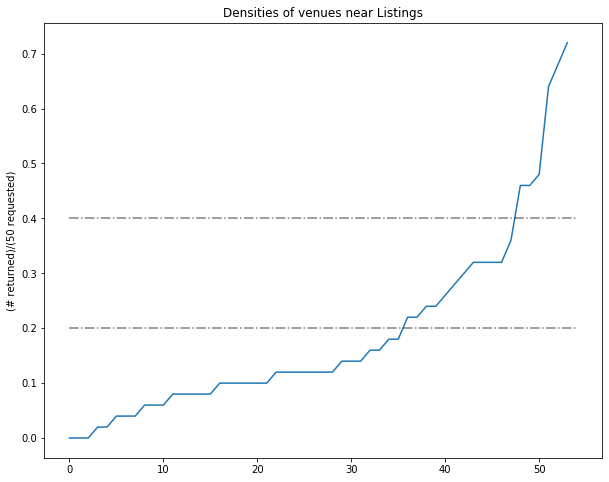

In [122]:
# Take a look at the density clusters.
Ls_densities.sort()
fig = plt.figure(figsize=(10, 8))
ax_densities = fig.add_subplot(111)
ax_densities.plot(Ls_densities)

xspace = np.linspace(0, len(Ls_densities), len(Ls_densities))
ax_densities.plot(xspace, np.full_like(xspace, 0.2, dtype=float), 'k-.', alpha=0.5)
ax_densities.plot(xspace, np.full_like(xspace, 0.4, dtype=float), 'k-.', alpha=0.5)

plt.title("Densities of venues near Listings")
plt.ylabel("(# returned)/(50 requested)")
plt.savefig("Densities_plot.png")

## 5. Results and analysis of the clusterings
To finish this notebook, we will do some analysis of the OPTICS clusterings found, to try to give some insight to our customers on the significance of the clusters. 

In [332]:
del cluster_means_sdevs

In [353]:
cluster_means = []
for j in range(-1, 5):
    this = listings_df[optics.labels_ == j]
    cluster_means.append((j, this['Coffee'].mean(), this['Library'].mean(), this['Bookstore'].mean(), this['Park_Playground'].mean(), this['School'].mean()))

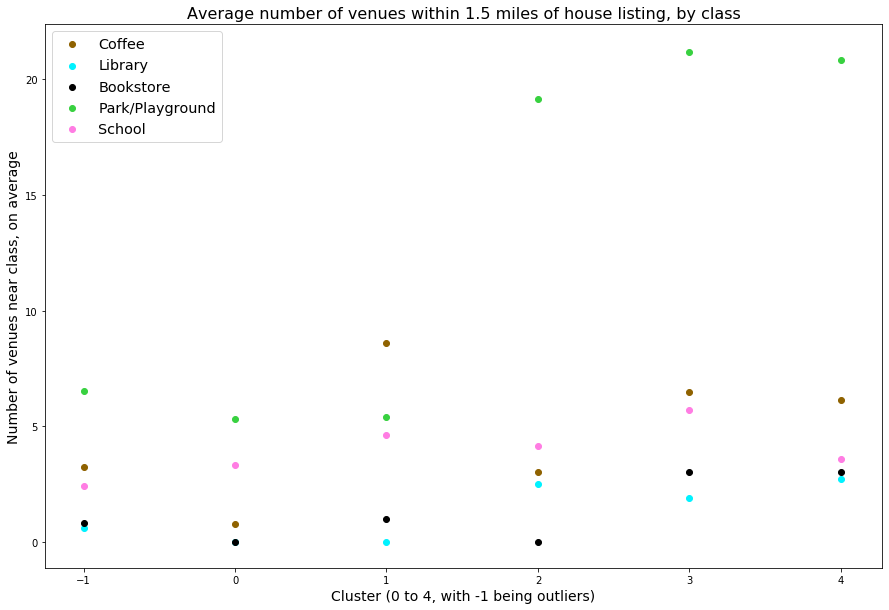

In [356]:
venue_names = ["Coffee",
    "Library",
    "Bookstore",
    "Park/Playground",
    "School"]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

for c in cluster_means:
    for j, y in enumerate(c[1:]):
        plt.scatter(c[0], y, c=venue_colors[j], label=venue_names[j])
        
ax.set_xlabel("Cluster (0 to 4, with -1 being outliers)", fontsize=14)
ax.set_ylabel("Number of venues near class, on average", fontsize=14)
ax.set_title("Average number of venues within 1.5 miles of house listing, by cluster", fontsize=16)
plt.xticks((-1, 0, 1, 2, 3, 4))
ax.legend(labels=venue_names, fontsize='x-large')
plt.savefig("Avg_venues.png")

In [358]:
cluster_means[3]

(2, 3.0, 2.5, 0.0, 19.166666666666668, 4.166666666666667)

In [331]:
cluster_means_sdevs[0]

(0,
 Density            0.104444
 Coffee             0.777778
 Library            0.000000
 Bookstore          0.000000
 Park_Playground    5.333333
 School             3.333333
 dtype: float64,
 Density            0.031269
 Coffee             0.833333
 Library            0.000000
 Bookstore          0.000000
 Park_Playground    2.179449
 School             0.500000
 dtype: float64)

# Thanks for checking out this Notebook!